## 학습목표

- Extractive/Abstractive summarization 이해하기
- 단어장 크기를 줄이는 다양한 text normalization 적용해보기
- seq2seq의 성능을 Up시키는 Attention Mechanism 적용하기

### 오늘 실습 예정인 개념들
- seq2seq를 사용합니다.
- RNN 계열 중 LSTM을 사용하므로 hidden state뿐만 아니라 cell state도 사용해야 합니다.
- 디코더의 예측 시퀀스에는 시작 토큰 SOS와 예측 토큰 EOS를 시퀀스의 앞, 뒤로 붙입니다.
- seq2seq를 구동시키면 디코더는 시작 토큰을 입력받아 예측을 시작합니다.
- seq2seq 기본 모델과 달리, 어텐션 메커니즘을 이용해 인코더의 hidden state의 중요도를 취합한 컨텍스트 벡터를 디코더 스텝별로 계산합니다.
- 계산된 컨텍스트 벡터를 이용해서 디코더는 다음 등장할 단어를 예측합니다.

### 데이터 준비하기

> 그리고 NLTK 라이브러리에 이미 등록된 불용어(stopwords)_-분석에 별로 의미 없는 단어들-_ 을 사용할 예정

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=3


In [2]:
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
# 약 56만개의 샘플이 있지만 10만개만 사용 예정

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 100000


In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


> 필요한 컬럼만 따로 저장해서 사용

In [4]:
data = data[['Text','Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
52679,Nothing makes me love fall more then pumpkin p...,Liquid Pie!
42147,"The millet flour was rancid, I wonder how long...",Rancid
89053,I have purchased these nuts a couple times. Th...,Fairly good value
94000,These Dried Dog Treats are great. My dog was ...,Great for Diabetic Dog
6581,Great seller. The product was as described. T...,Good stuff
80632,I was somewhat dubious when I ordered these so...,Just Like From a Candy Store!
46117,This is good loose leaf tea and the packaging ...,Good tea.
69604,"I've tried a variety of Earl Grey blends, and ...",Unique Earl Grey
41047,"I am very hard on food though, just ask my hus...","Pretty good, maybe not excellent =)"
63192,Well being a junk food junkie this is an easy ...,Tasty Snack!!


### 데이터 전처리하기

### (1) 중복값, Null이 있는 샘플 제거

In [6]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [10]:
print(len(data['Text']))
print(data['Text'].duplicated().sum())
print(len(data['Text'])-data['Text'].duplicated().sum())

100000
11574
88426


> summary는 중복이 있을 수 있지만, Text 부분의 중복은 진짜 중복이니 삭제

In [11]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


> 근데 Null 값이 중복으로 사라져도 1개는 있을 수 있으니 확인

In [12]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [13]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


#### 텍스트 정규화와 불용어 제거
-  `it'll`은 `it will`과 같고, `mustn't`과 `must not`은 같다.
- 이러한 걸 미리 줄여주면 연산량이 줄어든다.

In [15]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [16]:
# 불용어 없애주기
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [17]:
stopwords

<WordListCorpusReader in '/aiffel/nltk_data/corpora/stopwords'>

In [20]:
type(stopwords.words())

list

In [21]:
stopwords.words()[:5]

['إذ', 'إذا', 'إذما', 'إذن', 'أف']

> `stopwords.words()`만 하면 다 리스트로 불러오고, 사실 `words()` 안에 path를 넣으면 path에 저장된 게 불려져 오는 것 같다.

In [23]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


> 불용어 미제거는 추후 target 데이터로 쓰일 summary 부분에 영향을 끼친다.  
> 거기는 불용어가 있는 게 더 자연스러우니까.

In [24]:
# 임의의 text로 확인해보기
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [28]:
# 또 test
test_text = "If I write   (efe) #$# like this in order to test the function's efficiency, what would it produce?"
preprocess_sentence(test_text)

'write like order test function efficiency would produce'

In [29]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


> summary는 stopwords 사용 안 하기

In [30]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


In [31]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [32]:
# Null값 된 거 있는지 확인
data.isnull().sum()

Text        0
Summary    70
dtype: int64

In [33]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


### (2) 훈련데이터와 테스트데이터 나누기

#### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


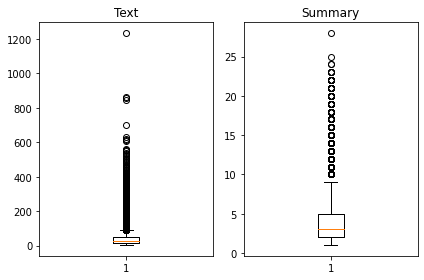

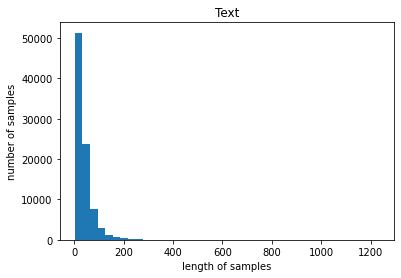

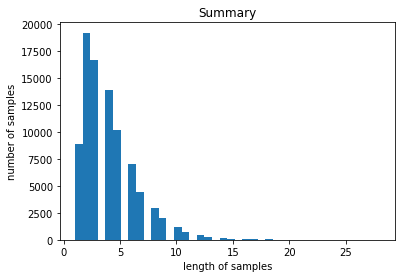

In [34]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [35]:
# 임의로 정한 max_len
text_max_len = 50
summary_max_len = 8
print('=3')

=3


In [38]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


--------------------------------------------------------------------

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


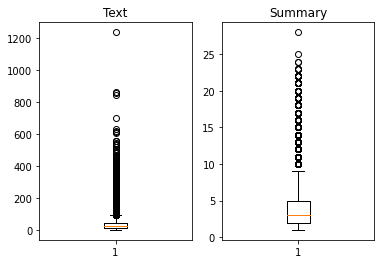

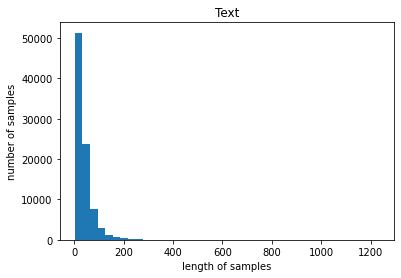

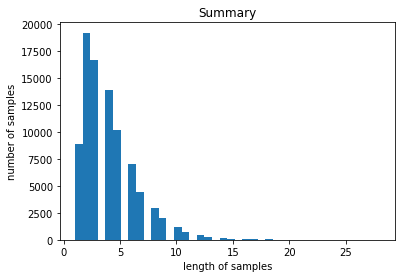

In [36]:
# # 길이 분포 출력
# import matplotlib.pyplot as plt

# text_len = [len(s.split()) for s in data['Text']]
# summary_len = [len(s.split()) for s in data['Summary']]

# print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
# print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
# print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
# print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
# print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
# print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

# plt.subplot(1,2,1)
# plt.boxplot(text_len)
# plt.title('Text')
# plt.subplot(1,2,2)
# plt.boxplot(summary_len)
# plt.title('Summary')
# # plt.tight_layout() # tight_layout() 안 하면 layout 안에 꽉 들어차게 들어가지 않는다.
# plt.show()

# plt.title('Text')
# plt.hist(text_len, bins = 40)
# plt.xlabel('length of samples')
# plt.ylabel('number of samples')
# plt.show()

# plt.title('Summary')
# plt.hist(summary_len, bins = 40)
# plt.xlabel('length of samples')
# plt.ylabel('number of samples')
# plt.show()

--------------------------------------------------------------------

In [39]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


> max_len을 정했으면 모든 데이터를 그것에 맞춰서 자를 건지, 아님 데이터 중 그것에 맞는 것만 가질 건지 정하면 되는데,  
> 내용이 잘리면 문맥상 이상해질 수 있으니 여기서는 제외한다고 함(약 23% 제외될 예정)

In [40]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


In [48]:
# DJ
# 이런 식으로 lambda 뒤에 반환 값으로 boolean 값을 넣을 수도 있음
data['Text'].apply(lambda x: len(x.split()) <= text_max_len)

0        True
1        True
2        True
3        True
4        True
         ... 
99993    True
99994    True
99995    True
99997    True
99998    True
Name: Text, Length: 65818, dtype: bool

#### 시작 토큰과 종료 토큰 추가하기

In [49]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [51]:
# 필요한 자료 넘파이 어레이로 저장하기
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


In [53]:
encoder_input[:2]

array(['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
       'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo'],
      dtype=object)

#### train, test 나누기

In [54]:
# 일단 인풋 데이터 갯수와 맞는 indices 만들고 섞기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[21581 14204 40943 ... 50248 22198  2096]


In [58]:
# permutation은 반환하고,
# shuffle은 called 된 것을 shuffle해줌
np.random.permutation(np.arange(len(encoder_input)))

array([52954, 55218, 52351, ..., 63761, 52490, 55588])

In [59]:
# 섞어주기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [60]:
# 8:2로 나눠주기
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13163


In [62]:
encoder_input.shape

(65818,)

In [61]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


### (3) 정수 인코딩

#### 단어 집합(vocabulary) 만들기 및 정수 인코딩


> keras의 `Tokenizer`를 사용하면 손 쉽게 단어 집합을 만들 수 있다.

In [63]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [64]:
Tokenizer()

In [65]:
src_tokenizer

In [66]:
src_tokenizer.word_index

{'like': 1,
 'good': 2,
 'great': 3,
 'taste': 4,
 'product': 5,
 'love': 6,
 'one': 7,
 'coffee': 8,
 'flavor': 9,
 'would': 10,
 'tea': 11,
 'really': 12,
 'get': 13,
 'amazon': 14,
 'price': 15,
 'best': 16,
 'buy': 17,
 'much': 18,
 'food': 19,
 'time': 20,
 'use': 21,
 'little': 22,
 'find': 23,
 'tried': 24,
 'better': 25,
 'also': 26,
 'well': 27,
 'make': 28,
 'chocolate': 29,
 'try': 30,
 'eat': 31,
 'dog': 32,
 'even': 33,
 'bought': 34,
 'delicious': 35,
 'found': 36,
 'sweet': 37,
 'order': 38,
 'could': 39,
 'cup': 40,
 'recommend': 41,
 'drink': 42,
 'tastes': 43,
 'used': 44,
 'loves': 45,
 'bag': 46,
 'sugar': 47,
 'favorite': 48,
 'cannot': 49,
 'first': 50,
 'store': 51,
 'free': 52,
 'nice': 53,
 'made': 54,
 'way': 55,
 'box': 56,
 'go': 57,
 'got': 58,
 'perfect': 59,
 'mix': 60,
 'dogs': 61,
 'water': 62,
 'since': 63,
 'easy': 64,
 'day': 65,
 'think': 66,
 'ordered': 67,
 'snack': 68,
 'bit': 69,
 'give': 70,
 'hot': 71,
 'flavors': 72,
 'two': 73,
 'many': 74,


> 여기서 등장 빈도가 7회 미만인 건 연산량을 줄이기 위해 제외할 예정

In [67]:
# 빈도 수 확인
src_tokenizer.word_counts.items()

odict_items([('use', 5126), ('product', 10814), ('dozens', 22), ('baking', 417), ('needs', 458), ('son', 925), ('allergic', 183), ('eggs', 261), ('dairy', 210), ('gluten', 1555), ('intolerant', 68), ('savior', 5), ('house', 918), ('good', 14861), ('loaf', 63), ('homemade', 278), ('bread', 999), ('fresh', 2128), ('bagels', 25), ('every', 2352), ('holiday', 112), ('season', 126), ('husband', 1311), ('makes', 2377), ('vegan', 213), ('fruit', 1200), ('cakes', 145), ('send', 265), ('relatives', 31), ('thanks', 851), ('pamela', 125), ('nervous', 37), ('ordering', 1031), ('one', 10008), ('reviewer', 229), ('said', 1024), ('ordered', 2489), ('two', 2417), ('bags', 1620), ('problem', 1008), ('rat', 20), ('terrier', 99), ('daughter', 841), ('standard', 236), ('schnauzer', 28), ('love', 10399), ('food', 5469), ('rejected', 8), ('several', 1174), ('brands', 1207), ('flavors', 2431), ('found', 3383), ('coats', 86), ('beautiful', 223), ('digest', 82), ('well', 4426), ('compare', 203), ('made', 2896)

In [70]:
src_tokenizer.word_counts

OrderedDict([('use', 5126),
             ('product', 10814),
             ('dozens', 22),
             ('baking', 417),
             ('needs', 458),
             ('son', 925),
             ('allergic', 183),
             ('eggs', 261),
             ('dairy', 210),
             ('gluten', 1555),
             ('intolerant', 68),
             ('savior', 5),
             ('house', 918),
             ('good', 14861),
             ('loaf', 63),
             ('homemade', 278),
             ('bread', 999),
             ('fresh', 2128),
             ('bagels', 25),
             ('every', 2352),
             ('holiday', 112),
             ('season', 126),
             ('husband', 1311),
             ('makes', 2377),
             ('vegan', 213),
             ('fruit', 1200),
             ('cakes', 145),
             ('send', 265),
             ('relatives', 31),
             ('thanks', 851),
             ('pamela', 125),
             ('nervous', 37),
             ('ordering', 1031),
             

In [71]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31949
등장 빈도가 6번 이하인 희귀 단어의 수: 23692
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8257
단어 집합에서 희귀 단어의 비율: 74.1556856239632
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.380007414748107


> 희한하게도 전체 단어의 약 75%가 등장 빈도에서는 약 3.3%만 차지하고 있다...

> 예상하기로 이렇게 많은 단어를 제외하고 훈련시키면,  
> - 장점은 훈련이 빠르게 진행되는 것이고  
> - 단점은 그만큼 많은 단어의 풍부함(어휘력)이 없어질 것이다.  
> - 하지만, 실제로 사용되는 횟수는 3%에 불과하다고 하니 없어도 무방할 듯하다...

In [72]:
# 어림잡아 8000개를 사용하는 단어로 잡는다
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [80]:
sorted([(v, k) for k, v in src_tokenizer.word_counts.items()], reverse=True)[:5]

[(15703, 'like'),
 (14861, 'good'),
 (14407, 'great'),
 (11624, 'taste'),
 (10814, 'product')]

In [81]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[21, 5, 4284, 562, 519, 274, 1092, 831, 993, 150, 2230, 278, 21, 2, 2340, 793, 249, 89, 3974, 79, 1593, 1459, 186, 78, 980, 201, 1321, 821, 3528, 297, 1465], [3194, 242, 7, 926, 245, 89, 67, 73, 145, 247, 4501, 1726, 306, 907, 3729, 6, 19, 7183, 208, 199, 72, 36, 19, 1887, 948, 1957, 5, 27], [1020, 5, 54, 73, 2492, 29, 351, 301, 3304, 458, 7, 4390, 376, 376, 39, 814, 4, 9, 434, 351, 301, 18, 2755, 4, 27, 148, 191, 29, 305]]


#### Summary에도 동일하게 수행

In [82]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [83]:
decoder_input_train[:3]

array(['sostoken gluten free versatile and tastes good',
       'sostoken arrived quickly and it was fresh',
       'sostoken awesome cocoa'], dtype=object)

> 위에처럼 단어 사전을 만들면서 부여된 정수는 `word_index`를 통해 확인 가능

> Summary도 빈도수를 기준으로 수치가 낮은 단어들은 걸러내기

In [85]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10515
등장 빈도가 5번 이하인 희귀 단어의 수: 8138
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2377
단어 집합에서 희귀 단어의 비율: 77.39419876367096
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.907358356482977


In [86]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 81, 53, 667, 10, 59, 4], [1, 405, 820, 10, 11, 110, 137], [1, 41, 189], [1, 9, 15, 14], [1, 27, 1669]]
target
decoder  [[81, 53, 667, 10, 59, 4, 2], [405, 820, 10, 11, 110, 137, 2], [41, 189, 2], [9, 15, 14, 2], [27, 1669, 2]]


> 근데 이렇게 num_words를 설정해서 자꾸 단어들을 날리면, 단어 사전에 없는 단어를 가진 원본 텍스트는 정수 인코딩 후에 empty로 되어 있을 수 있다.

> 그렇게 empty가 된 건 그래도 빈도수가 제일 높은 시작, 종료 토큰은 있을 테니까 길이가 1이 된다.  
> 그래서 길이가 1인 문장들을 또 걸러낸다

> 이 때 encoder 부분도 확인하면 좋지만, 가정으로 깔고 가는 건, 원래 문장이 긴 것이다 보니 empty로 바뀐 건 없을 것이란 거다

In [87]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1246
삭제할 테스트 데이터의 개수 : 329
훈련 데이터의 개수 : 51409
훈련 레이블의 개수 : 51409
테스트 데이터의 개수 : 12834
테스트 레이블의 개수 : 12834


#### 패딩하기

In [88]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


In [90]:
encoder_input_train[:2]

array([[  21,    5, 4284,  562,  519,  274, 1092,  831,  993,  150, 2230,
         278,   21,    2, 2340,  793,  249,   89, 3974,   79, 1593, 1459,
         186,   78,  980,  201, 1321,  821, 3528,  297, 1465,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [3194,  242,    7,  926,  245,   89,   67,   73,  145,  247, 4501,
        1726,  306,  907, 3729,    6,   19, 7183,  208,  199,   72,   36,
          19, 1887,  948, 1957,    5,   27,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]], dtype=int32)

In [91]:
encoder_input_train.shape

(51409, 50)

## 모델 설계하기

> Functional API 사용

> 여기서 hidden_size는 LSTM에서 hidden_state의 뉴런 개수라고 이해하면 됨

In [92]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,)) # DJ - 아마도 여기 text_max_len만 넣는 건 데이터 갯수를 모른다는 가정으로 feature만 넣은 듯하다.

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs) # DJ - 근데 임베딩 층에서는 (8000개, 원하는 벡터 차원수)를 명시해준다.

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [93]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

-----------------------------------------------------------------

In [95]:
decoder_inputs

<KerasTensor: shape=(None, None) dtype=float32 (created by layer 'input_2')>

In [96]:
dec_emb_layer

In [97]:
dec_emb

<KerasTensor: shape=(None, None, 128) dtype=float32 (created by layer 'embedding_1')>

In [98]:
decoder_lstm

In [99]:
decoder_outputs

<KerasTensor: shape=(None, None, 256) dtype=float32 (created by layer 'lstm_3')>

-----------------------------------------------------------------

> 출력층 첫번째 `Dense()`은 전체 target_vocab 숫자의 확률을 반환해야 하기 때문에 `뉴런 개수`로 그 값을 넣는다.

In [100]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

#### 위는 기본적인 LSTM이니, attention 매커니즘을 쓴 모델도 써보자

> 아래의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동

In [102]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 모델 훈련하기

In [103]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
201/201 [==============================] - 124s 570ms/step - loss: 3.1242 - val_loss: 2.4109
Epoch 2/50
201/201 [==============================] - 114s 566ms/step - loss: 2.4021 - val_loss: 2.2703
Epoch 3/50
201/201 [==============================] - 114s 565ms/step - loss: 2.2528 - val_loss: 2.1498
Epoch 4/50
201/201 [==============================] - 114s 567ms/step - loss: 2.1304 - val_loss: 2.0590
Epoch 5/50
201/201 [==============================] - 114s 567ms/step - loss: 2.0188 - val_loss: 2.0054
Epoch 6/50
201/201 [==============================] - 114s 566ms/step - loss: 1.9495 - val_loss: 1.9615
Epoch 7/50
201/201 [==============================] - 114s 566ms/step - loss: 1.9042 - val_loss: 1.9373
Epoch 8/50
201/201 [==============================] - 114s 567ms/step - loss: 1.8537 - val_loss: 1.9109
Epoch 9/50
201/201 [==============================] - 114s 566ms/step - loss: 1.8001 - val_loss: 1.8914
Epoch 10/50
201/201 [==============================] - 114s 566m

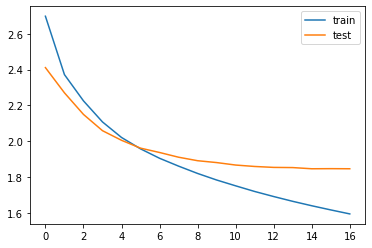

In [104]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인퍼런스 모델 구현하기

> 테스트할 때는 정수 -> 단어로 구현되어야 하니까 그것에 필요한 것들을 준비한다.

In [105]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [108]:
src_tokenizer.index_word

{1: 'like',
 2: 'good',
 3: 'great',
 4: 'taste',
 5: 'product',
 6: 'love',
 7: 'one',
 8: 'coffee',
 9: 'flavor',
 10: 'would',
 11: 'tea',
 12: 'really',
 13: 'get',
 14: 'amazon',
 15: 'price',
 16: 'best',
 17: 'buy',
 18: 'much',
 19: 'food',
 20: 'time',
 21: 'use',
 22: 'little',
 23: 'find',
 24: 'tried',
 25: 'better',
 26: 'also',
 27: 'well',
 28: 'make',
 29: 'chocolate',
 30: 'try',
 31: 'eat',
 32: 'dog',
 33: 'even',
 34: 'bought',
 35: 'delicious',
 36: 'found',
 37: 'sweet',
 38: 'order',
 39: 'could',
 40: 'cup',
 41: 'recommend',
 42: 'drink',
 43: 'tastes',
 44: 'used',
 45: 'loves',
 46: 'bag',
 47: 'sugar',
 48: 'favorite',
 49: 'cannot',
 50: 'first',
 51: 'store',
 52: 'free',
 53: 'nice',
 54: 'made',
 55: 'way',
 56: 'box',
 57: 'go',
 58: 'got',
 59: 'perfect',
 60: 'mix',
 61: 'dogs',
 62: 'water',
 63: 'since',
 64: 'easy',
 65: 'day',
 66: 'think',
 67: 'ordered',
 68: 'snack',
 69: 'bit',
 70: 'give',
 71: 'hot',
 72: 'flavors',
 73: 'two',
 74: 'many',


> inference 할 때는 인코더, 디코더 각각 모델을 만들어줘야 한다.  
> 왜냐하면 훈련 때는 디코더에서 출력되는 것과 정답을 한꺼번에 확인할 수 있지만,  
> inference 할 때는 디코더가 만들어질 문장만큼 반복 구조로 동작해야 하기 때문에(offset) 따로 만들어줘야 한다.

In [109]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


> 어텐션 메커니즘 사용하는 출력층 설계

In [110]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


> 단어 완성하는 함수 정의

In [111]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


## 모델 테스트하기

> - 해석하기 쉽게 정수->텍스트로 만들어주는 함수 만들기  
> - Text에서는 패딩인 0만 제외하고  
> - Summary에서는 시작토큰과 종료토큰도 제외

In [112]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


> 테스트로 50개만 해보기

In [113]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : friend mine sweet enough buy discovered tiny market still grateful willing buy without knowing good even favourite spaghetti sauce could hide pasty wet dog pasta gives flavour forget directions followed stuff worth one table liked stuff another disappointing gluten free pasta waste money 
실제 요약 : awful 
예측 요약 :  not bad


원문 : found better english style tea usa brew one cup time usually add splash milk table sugar flavorful comforting 
실제 요약 : delicious english style tea 
예측 요약 :  great tea


원문 : love product organic use making whole grain breads grind flour electric stone flour mill years like real quality ingredients homemade products organic valley milk one ingredients 
실제 요약 : good quality at great value 
예측 요약 :  great product


원문 : always love salmon however difficult eat go packages filled void perfection drawback small portion size price otherwise product exceptional salmon overly dried still contains small amount moisture allow pleasant eating experience order bags mont

예측 요약 :  great tasting snack


원문 : contain organic ingredients doggies gobbled say dog treat one dogs little fussy sometimes turns nose treats problem asking math decide organic dog treats worth extra cash giving dogs healthiest treats priority cannot see going wrong cannot comment flavor 
실제 요약 : the doggies loved them 
예측 요약 :  my dogs loved them


원문 : everyone loves chocolate wafer used make cake look like box impressive company excellent customer service helpful sending replacement shipment broken purchasing future 
실제 요약 : great gift for dad 
예측 요약 :  great product


원문 : first purchase water tastes great bottles thicker also everyone likes name haha 
실제 요약 : great tasting water 
예측 요약 :  great product


원문 : began using product four weeks ago absolutely love thrown given away products used hair stronger soft color relax hair since using breakage healing hair increasingly less use damage color along ultra shea products sold product try regret really says 
실제 요약 : wonderful 
예측 요

## 결론
- 좋은 요약도 있고, 안 좋은 요약도 있는데 seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법도 있고, 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding), 또는 인코더 <-> 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)를 적용하면 성능이 개선된다.


---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------

## 추출적 요약 해보기

- 위에는 추상적 요약을 진행했음
- `summa` 패키지를 통해 간단히 해볼 수 있음

In [114]:
!pip list | grep summa

summa                         1.2.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### 데이터 다운로드하기

In [115]:
import requests
from summa.summarizer import summarize

In [116]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [117]:
# 매트릭스의 시놉시스임
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

## summarize 사용하기

> 파라미터 설명
> - text (str) : 요약할 테스트.
> - ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
> - words (int or None, optional) – 출력에 포함할 단어 수. 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
> - split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [118]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


> `summa`의 `summarize()`는 별도로 토큰화 하지 않아도 됨. 내부적으로 알아서 함

In [119]:
# join해서 문장(str)로 반환하지말고 list로 반환하기
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [120]:
# 단어 수 선택
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
